In [1]:
import pandas as pd
import numpy as np
import os.path
import csv
import operator

In [2]:
# 영화 300개 자료 저장
# User 수는 1000명
data = {}
movie_id = 0
user_name = 0
rating = 0
user_list = []


with open('combined_data_1.txt', 'r') as f:
    for line in f:
        if(line.find(":") != -1):
            continue
        line_split = line.split(',')
        user_name = int(line_split[0])
        if user_name in user_list:
            continue
        else:
            user_list.append(user_name)
        if len(user_list) > 1000:
            break

with open('combined_data_1.txt', 'r') as f:
    for line in f:
        if(line.find(":") != -1):
            movie_id = int(line.replace(":","")) - 1
            if(movie_id >= 300): break
            data[movie_id] = {}
        else:
            line_split = line.split(',')
            user_name = int(line_split[0])
            rating = int(line_split[1])
            if user_name in user_list:
                data[movie_id][user_name] = rating

#### Implicit_data를 만들기 위해서 Rating_data의 내용을 변경
- Rating의 값이 있다는 것은 관심있다 라고 가정. Rating이 있는 값 모두 1로 변경

- Rating이 없는 값은 관심이 없는 것으로 간주하고 모두 0으로 변경

In [3]:
r_lambda = 40
nf = 200
alpha = 40

In [13]:
matrix = np.zeros((1000,300))

for i in range(1000):
    for j in range(300):
        if(user_list[i] in data[j]):
            matrix[i][j] = data[j][user_list[i]]
        
R = np.array(matrix)

R

array([[3., 0., 0., ..., 0., 3., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.]])

In [14]:
nu = R.shape[0]
ni = R.shape[1]

# initialize X and Y with very small values
X = np.random.rand(nu, nf) * 0.01
Y = np.random.rand(ni, nf) * 0.01

print(X)

[[6.14193510e-03 2.43284081e-05 7.06951738e-03 ... 4.16492001e-03
  5.62570745e-03 3.64816843e-04]
 [3.63279965e-03 7.00735762e-03 3.34715694e-03 ... 9.20516939e-03
  2.21059288e-03 5.62069129e-03]
 [9.91290748e-04 1.15255237e-03 6.58139468e-03 ... 5.81835981e-03
  7.62367780e-03 3.11635007e-03]
 ...
 [9.33165832e-04 4.86533550e-03 9.88848136e-03 ... 3.54549704e-04
  1.71418977e-03 7.23999179e-03]
 [3.25297203e-03 5.18407234e-03 2.57004027e-03 ... 5.98667818e-04
  6.23847667e-03 2.40932534e-03]
 [5.31539403e-03 2.37638509e-03 7.97653275e-03 ... 8.25487273e-03
  6.58113317e-03 6.82583269e-03]]


In [15]:
P = np.copy(R)
P[P > 0] = 1
print(P)

[[1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [16]:
C = 1 + alpha * R
print(C)

[[121.   1.   1. ...   1. 121.   1.]
 [201.   1.   1. ...   1.   1.   1.]
 [161.   1.   1. ...   1.   1.   1.]
 ...
 [  1.   1. 161. ...   1.   1.   1.]
 [  1.   1. 201. ...   1.   1.   1.]
 [  1.   1. 121. ...   1.   1.   1.]]


In [17]:
def loss_function(C, P, xTy, X, Y, r_lambda):
    predict_error = np.square(P - xTy)
    confidence_error = np.sum(C * predict_error)
    regularization = r_lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))
    total_loss = confidence_error + regularization
    return np.sum(predict_error), confidence_error, regularization, total_loss

In [18]:
def optimize_user(X, Y, C, P, nu, nf, r_lambda):
    yT = np.transpose(Y)
    for u in range(nu):
        Cu = np.diag(C[u])
        yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y)
        lI = np.dot(r_lambda, np.identity(nf))
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)

def optimize_item(X, Y, C, P, ni, nf, r_lambda):
    xT = np.transpose(X)
    for i in range(ni):
        Ci = np.diag(C[:, i])
        xT_Ci_x = np.matmul(np.matmul(xT, Ci), X)
        lI = np.dot(r_lambda, np.identity(nf))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

In [19]:
predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in range(15):
    if i!=0:   
        optimize_user(X, Y, C, P, nu, nf, r_lambda)
        optimize_item(X, Y, C, P, ni, nf, r_lambda)
    predict = np.matmul(X, np.transpose(Y))
    predict_error, confidence_error, regularization, total_loss = loss_function(C, P, predict, X, Y, r_lambda)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)
    
    print('----------------step %d----------------' % i)
    print("predict error: %f" % predict_error)
    print("confidence error: %f" % confidence_error)
    print("regularization: %f" % regularization)
    print("total loss: %f" % total_loss)
    
predict = np.matmul(X, np.transpose(Y))
print('final predict')
print([predict])

----------------step 0----------------
predict error: 14987.483896
confidence error: 1902126.688578
regularization: 346.601470
total loss: 1902473.290048
----------------step 1----------------
predict error: 29858.646379
confidence error: 92888.902388
regularization: 384403.970091
total loss: 477292.872478
----------------step 2----------------
predict error: 8004.386078
confidence error: 12980.663014
regularization: 81834.043029
total loss: 94814.706044
----------------step 3----------------
predict error: 7943.362883
confidence error: 11915.926734
regularization: 72533.429388
total loss: 84449.356122
----------------step 4----------------
predict error: 8225.604533
confidence error: 11809.791421
regularization: 69038.167621
total loss: 80847.959041
----------------step 5----------------
predict error: 8529.252353
confidence error: 11900.898674
regularization: 66932.837165
total loss: 78833.735839
----------------step 6----------------
predict error: 8805.882614
confidence error: 1204

<Figure size 432x288 with 0 Axes>

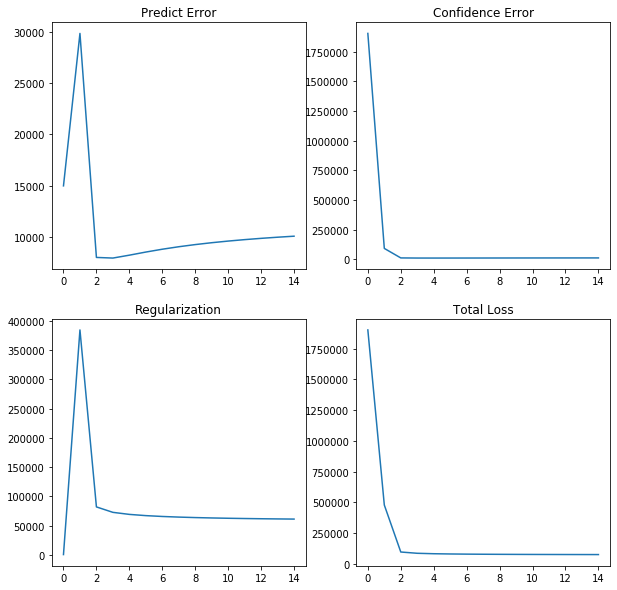

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()